In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ten_stocks = pd.read_csv('30min_df.csv')

In [5]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

## Ljung Box Test and Dicket Fuller Test of price

In [6]:
import statsmodels.api as sm

# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput['p-value']  # p<0.05, Stationary

results = pd.DataFrame(columns=['stock', 'ljung_p', 'dickey-fuller_p'])
for stock_name in pool:
    result = {'stock': stock_name, 'ljung_p': sm.stats.acorr_ljungbox(ten_stocks[stock_name].dropna(), lags=[12], return_df=True)['lb_pvalue'].values[0]
             , 'dickey-fuller_p': test_stationarity(ten_stocks[stock_name].dropna())}
    results = results.append(result, ignore_index=True) 
results

,stock,ljung_p,dickey-fuller_p
0,600094.XSHG,0.0,0.336184
1,600160.XSHG,0.0,0.001549
2,600008.XSHG,0.0,0.035244
3,600903.XSHG,0.0,0.007036
4,000959.XSHE,0.0,0.353838
5,600970.XSHG,0.0,0.011225
6,002302.XSHE,0.0,0.136667
7,600823.XSHG,0.0,0.036659
8,002503.XSHE,0.0,0.486607
9,600664.XSHG,0.0,0.364086


## Price plot

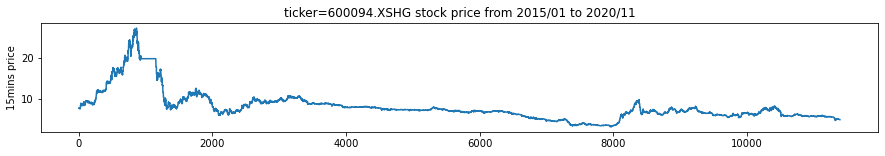

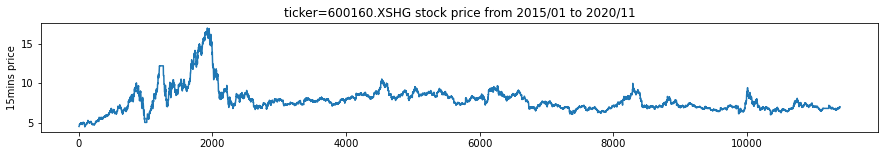

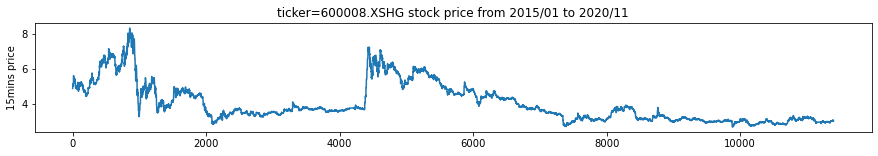

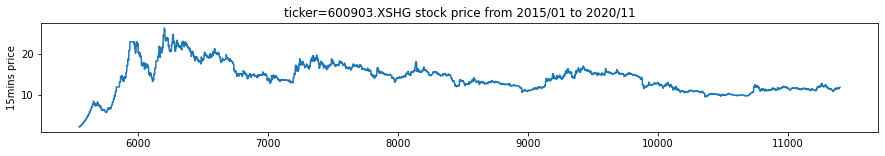

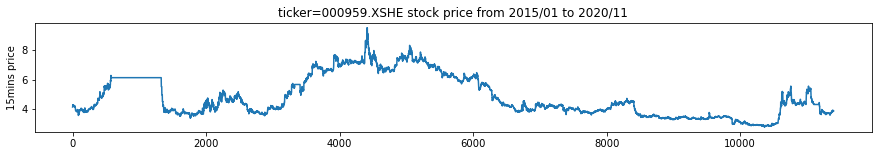

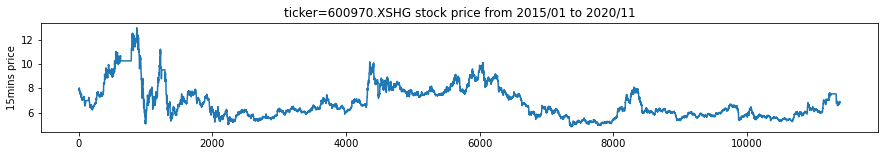

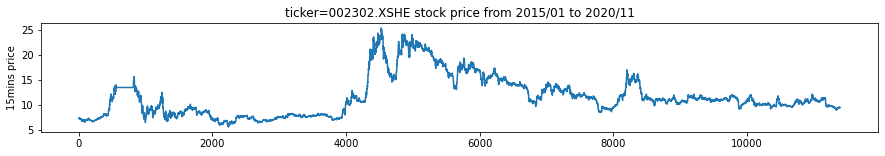

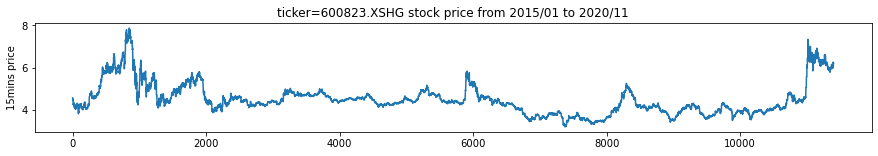

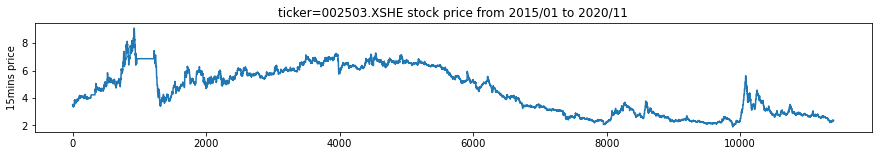

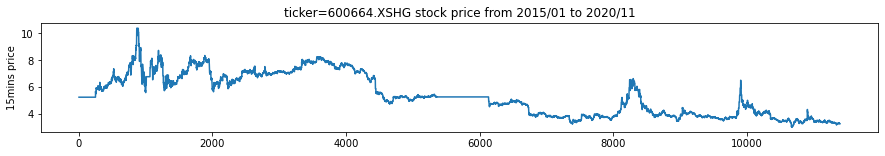

In [8]:
for stock_name in pool:
    ten_stocks[stock_name].dropna().plot(figsize=(15,2))
    plt.ylabel('15mins price')
    plt.title('ticker='+stock_name+' stock price from 2015/01 to 2020/11')
    plt.show()

## Log return plot + ACF/PACF

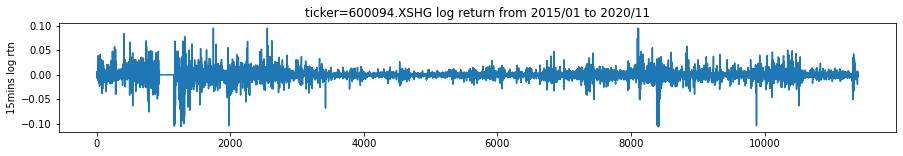

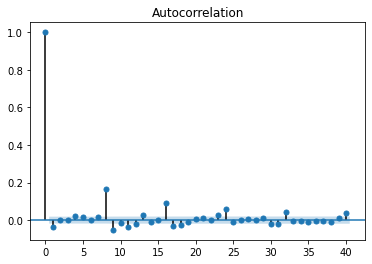

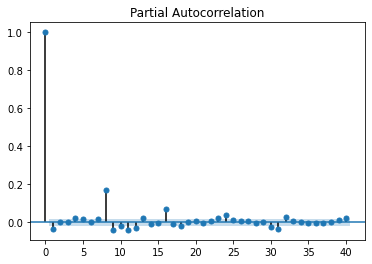

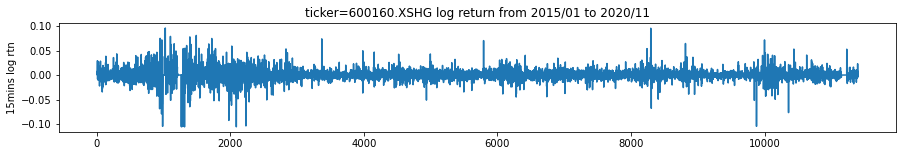

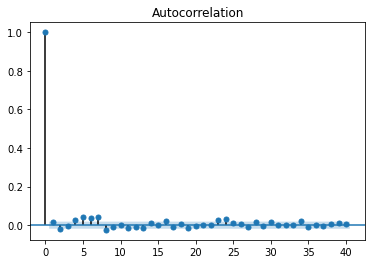

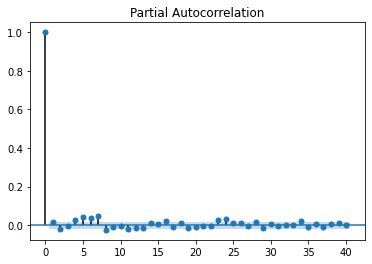

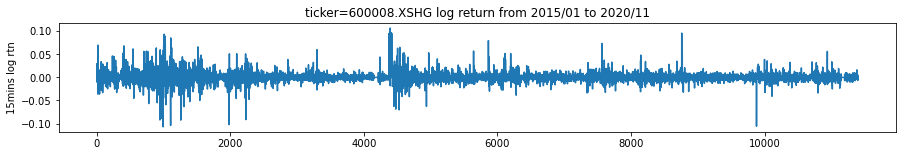

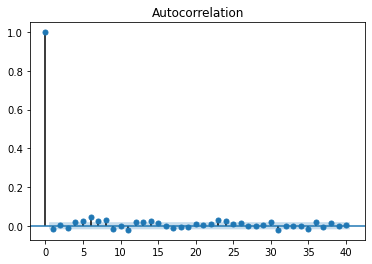

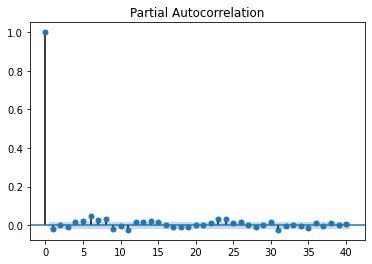

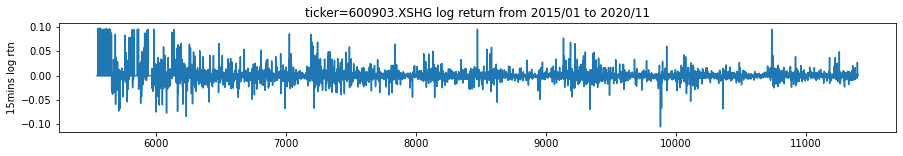

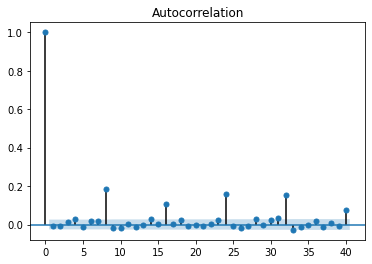

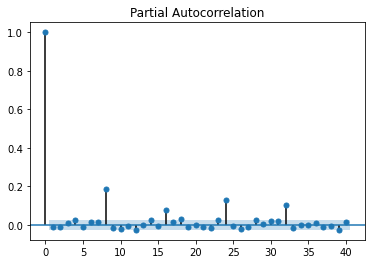

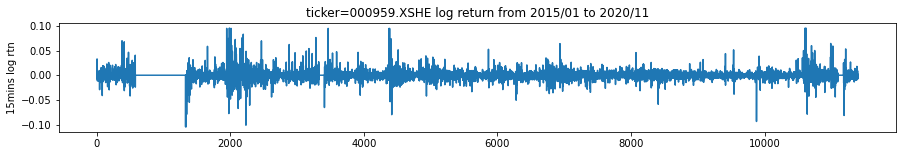

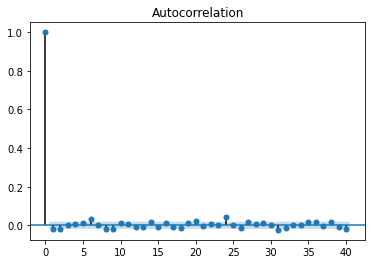

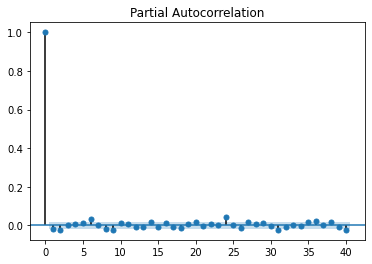

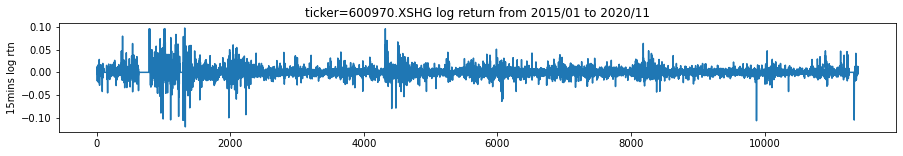

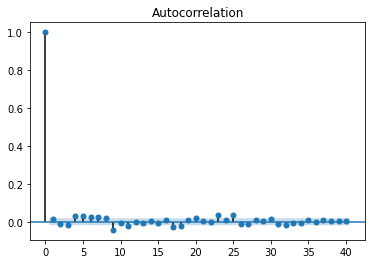

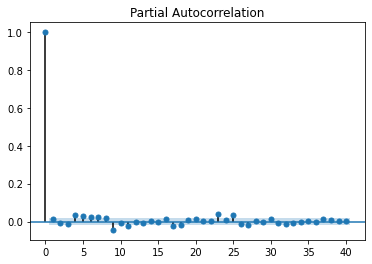

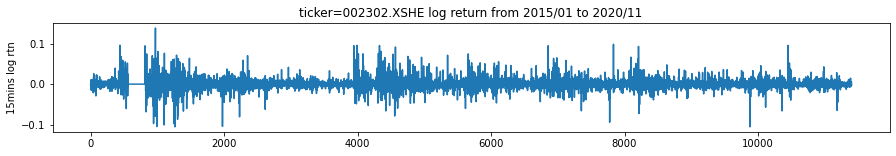

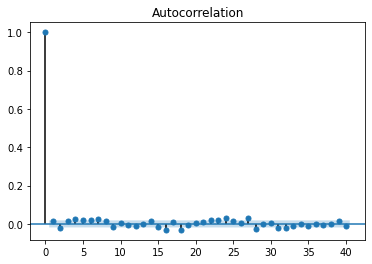

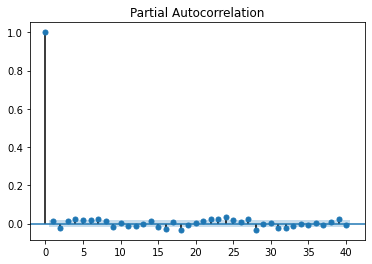

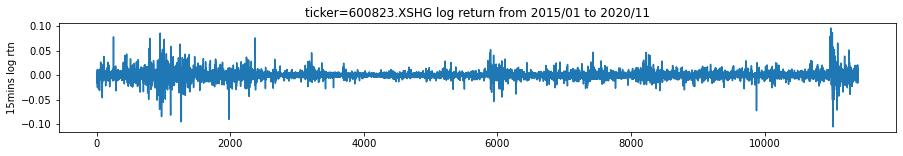

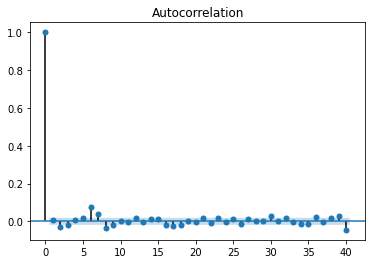

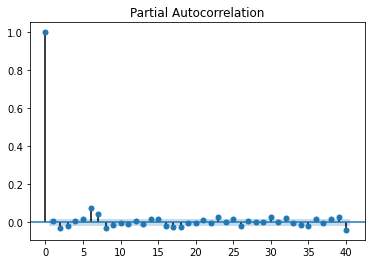

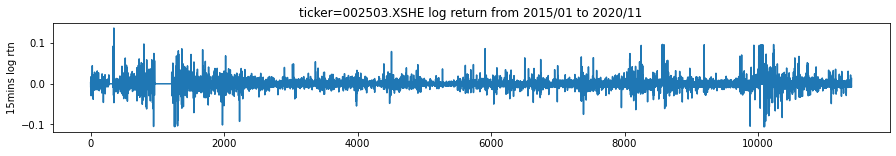

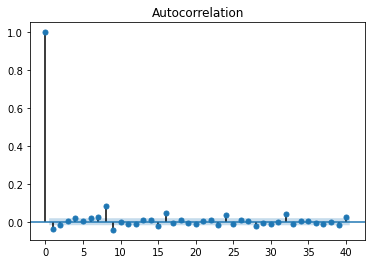

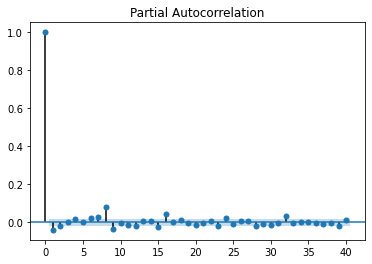

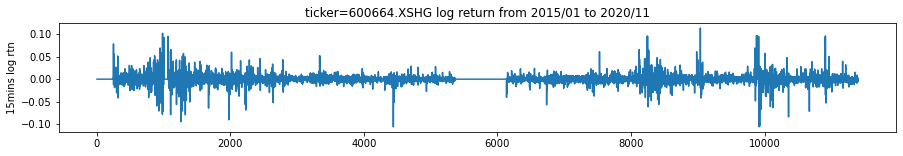

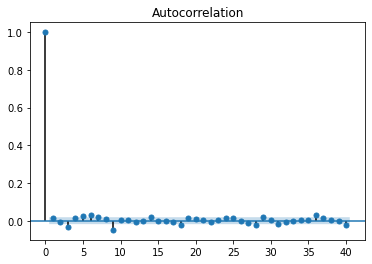

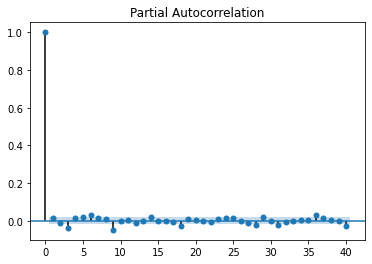

In [9]:
log_rtn_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_ten[stock_name] = log_rtn
    log_rtn.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn')
    plt.title('ticker='+stock_name+' log return from 2015/01 to 2020/11')
    plt.show()
    sm.graphics.tsa.plot_acf(log_rtn, lags=40) 
    plt.show()
    sm.graphics.tsa.plot_pacf(log_rtn, lags=40)
    plt.show()

## GARCH

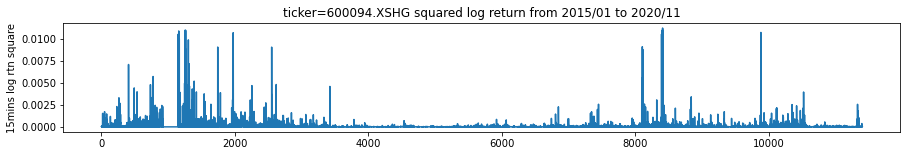

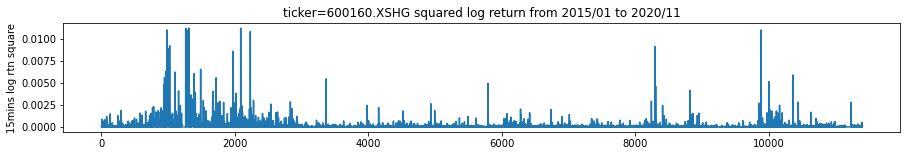

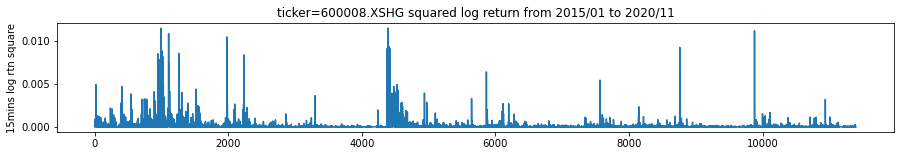

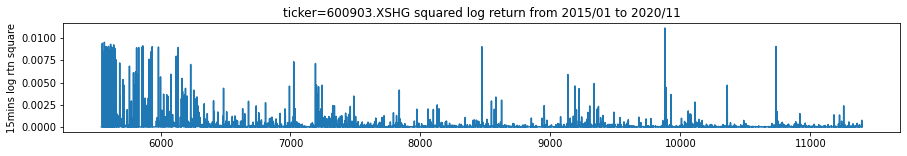

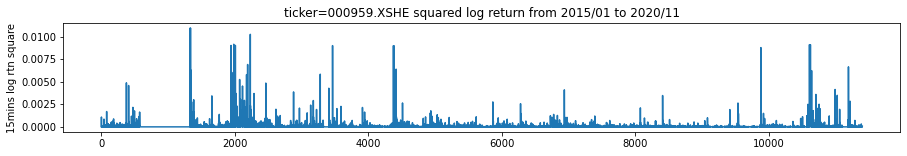

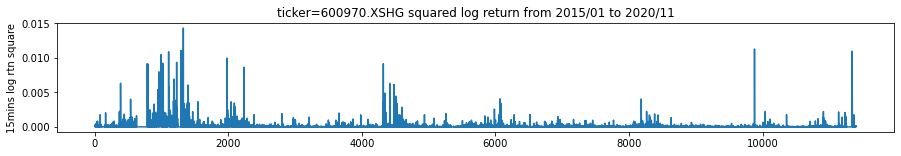

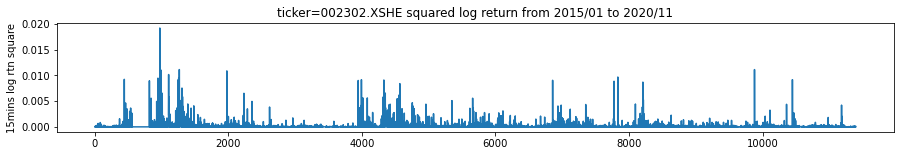

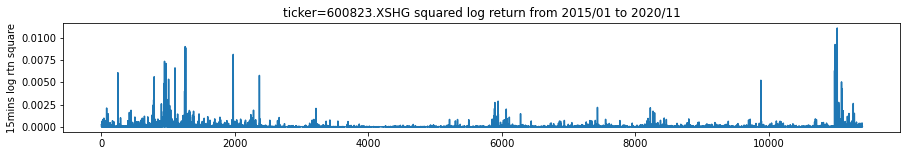

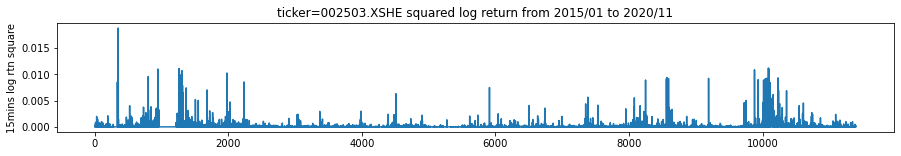

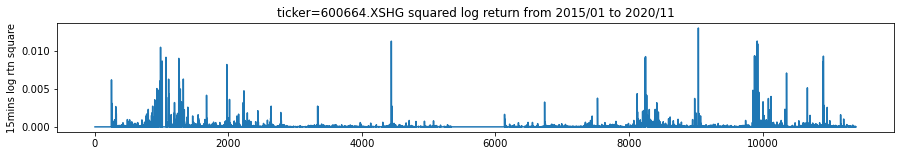

In [10]:
log_rtn_square_ten = {}
for stock_name in pool:
    log_rtn = np.log(ten_stocks[stock_name]).diff(1).dropna()
    log_rtn_square = np.square(log_rtn - log_rtn.mean())
    log_rtn_square_ten[stock_name] = log_rtn_square
    log_rtn_square.plot(figsize=(15,2))
    plt.ylabel('15mins log rtn square')
    plt.title('ticker='+stock_name+' squared log return from 2015/01 to 2020/11')
    plt.show()

In [11]:
import statsmodels.api as sm

results = pd.DataFrame(columns=['stock_name', 'ljung_p'])

for stock_name in pool:
    p_2 = sm.stats.acorr_ljungbox(log_rtn_square_ten[stock_name], lags=[40], return_df=True)['lb_pvalue'].values[0]
    result = {'stock_name': stock_name, 'ljung_p': p_2}
    results = results.append(result, ignore_index=True)
    
results[results['ljung_p']<0.05]

,stock_name,ljung_p
0,600094.XSHG,0.0
1,600160.XSHG,0.0
2,600008.XSHG,0.0
3,600903.XSHG,0.0
4,000959.XSHE,0.0
5,600970.XSHG,0.0
6,002302.XSHE,0.0
7,600823.XSHG,0.0
8,002503.XSHE,0.0
9,600664.XSHG,0.0


In [12]:
stocks_with_ARCH = results[results['ljung_p']<0.05]['stock_name'].values

In [ ]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_GARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        model = arch_model(log_rtn_ten[stock_name], mean='constant', p=p, q=q)
    
        res = model.fit(update_freq=0)
    
        ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
        aic = res.aic
        
        result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
        results = results.append(result, ignore_index=True)


for pq in combinations:
    train_GARCH(pq)



In [14]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,p,q,params,ljung_p,aic,stock_name
4,1,1,mu -0.000006 omega 0.000002 alph...,0.114980,-78638.071387,000959.XSHE
78,2,4,mu 2.776045 omega 0.000003 alph...,0.460751,104255.593683,002503.XSHE
153,4,4,mu -0.000012 omega 0.000003 alph...,0.051437,-36181.152603,600903.XSHG


## EGARCH

In [ ]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,5)
q = range(1,5)

combinations = list(itertools.product(p, q))
results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

def train_EGARCH(param):
    global results
    p = param[0]
    q = param[1]
    
    
    for stock_name in stocks_with_ARCH:
        try:
            model = arch_model(log_rtn_ten[stock_name], vol='EGARCH', mean='constant', p=p, q=q, dist='t')

            res = model.fit(update_freq=0)

            ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
            aic = res.aic

            result = {'stock_name': stock_name, 'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}
            results = results.append(result, ignore_index=True)
        except:
            continue


for pq in combinations:
    train_EGARCH(pq)



In [16]:
results.loc[results[results['ljung_p']>=0.05].groupby(by=["stock_name"])['aic'].idxmin()]

,p,q,params,ljung_p,aic,stock_name
59,2,3,mu 1.014173 omega -18.610118 al...,0.999984,105115.878460,000959.XSHE
109,3,4,mu -17.408058 omega -18.048397 ...,1.000000,107518.741829,002302.XSHE
34,1,4,mu 4.737383 omega -0.891879 al...,0.059757,80415.219685,002503.XSHE
95,3,3,mu -2.024349e-10 omega -6.202285e...,0.962603,72674.625030,600008.XSHG
65,2,4,mu 9.233105 omega -0.000647 ...,1.000000,98466.441405,600094.XSHG
56,2,3,mu -5.119831 omega -1.605974 ...,1.000000,81606.410058,600160.XSHG
8,1,1,mu 24.801560 omega -0.166479 al...,1.000000,106855.768895,600664.XSHG
127,4,2,mu -9.507283e-11 omega -5.558792e...,0.337682,71269.971864,600823.XSHG
58,2,3,mu -17.448199 omega 0.520765 al...,1.000000,52743.803299,600903.XSHG
4,1,1,mu -4.282104 omega 0.040360 al...,1.000000,79429.595551,600970.XSHG
